In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# 1.0 Process Data 

In [82]:
name = "maven-maven-3.0r"
df = pd.read_csv(name + '.csv')
# df = df.fillna("Nil")
file = df[df['Kind'] == 'File']
file = file[file.apply(lambda row: (row['Name'][-5:] == ".java"), axis=1)]
df = file
df = df.drop(columns = ['Kind'])
print("original col #:        "+str(len(df.columns)))
df = df.dropna(axis='columns')
print("after drop NaN, col #: "+str(len(df.columns)))
df.head(5)

original col #:        76
after drop NaN, col #: 41


,Name,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,...,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,MaxEssential,MaxNesting,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
5,maven-maven-3.0/apache-maven/src/test/java/org...,1.0,1.0,1.0,1.0,18.0,2.0,16.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1,0.89,1,1,1,1
8,maven-maven-3.0/maven-aether-provider/src/main...,3.0,3.0,3.0,1.0,20.0,1.0,18.0,0.0,1.0,...,15.0,15.0,16.0,10.0,4,0.06,52,52,54,25
9,maven-maven-3.0/maven-aether-provider/src/main...,1.0,1.0,2.0,1.0,8.0,0.0,7.0,0.0,2.0,...,3.0,3.0,7.0,3.0,1,0.31,10,10,14,9
10,maven-maven-3.0/maven-aether-provider/src/main...,1.0,1.0,1.0,1.0,11.0,1.0,10.0,0.0,1.0,...,2.0,2.0,2.0,1.0,1,0.31,7,7,7,5
11,maven-maven-3.0/maven-aether-provider/src/main...,1.0,1.0,1.0,1.0,11.0,0.0,8.0,3.0,1.0,...,1.0,1.0,1.0,1.0,0,1.71,1,1,1,1


In [83]:
def drop_relative_path(s):
    return s.replace(".../","")

In [84]:
bug = pd.read_csv('maven_bugs.txt')
bug = bug.drop_duplicates()
bug['Name'] = bug['Name'].apply(drop_relative_path)
bug.index = range(len(bug.index))
bug.head(5)

,Name
0,DefaultPluginManagementInjector.java
1,model/validation/DefaultModelValidator.java
2,validation/DefaultModelValidatorTest.java
3,maven/cli/logging/impl/Slf4jSimpleConfiguratio...
4,main/java/org/slf4j/impl/MavenSlf4jSimpleFrien...


In [85]:
df['Label'] = 0 
# counter = 0
for i in range(len(bug)) : 
#     if(df["Name"].str.contains(bug["Name"][i]).sum()>0):
#         print(counter)
#         counter = counter + 1
#         print("current label: "+ str(df.loc[df["Name"].str.contains(bug["Name"][i]),"Label"]))
#         print("bug Name: "+bug["Name"][i])
#         print("colum name: "+ str(df.loc[df["Name"].str.contains(bug["Name"][i]),"Name"][-20:]))
#         print(df["Label"].sum())
#         print()
    df.loc[df["Name"].str.contains(bug["Name"][i]),"Label"] = 1
df["Label"].sum()

189

In [86]:
df.to_csv( name + '_preprocessed.csv')

# 2.0 feature selection

## 2.1 Filter: correlation 

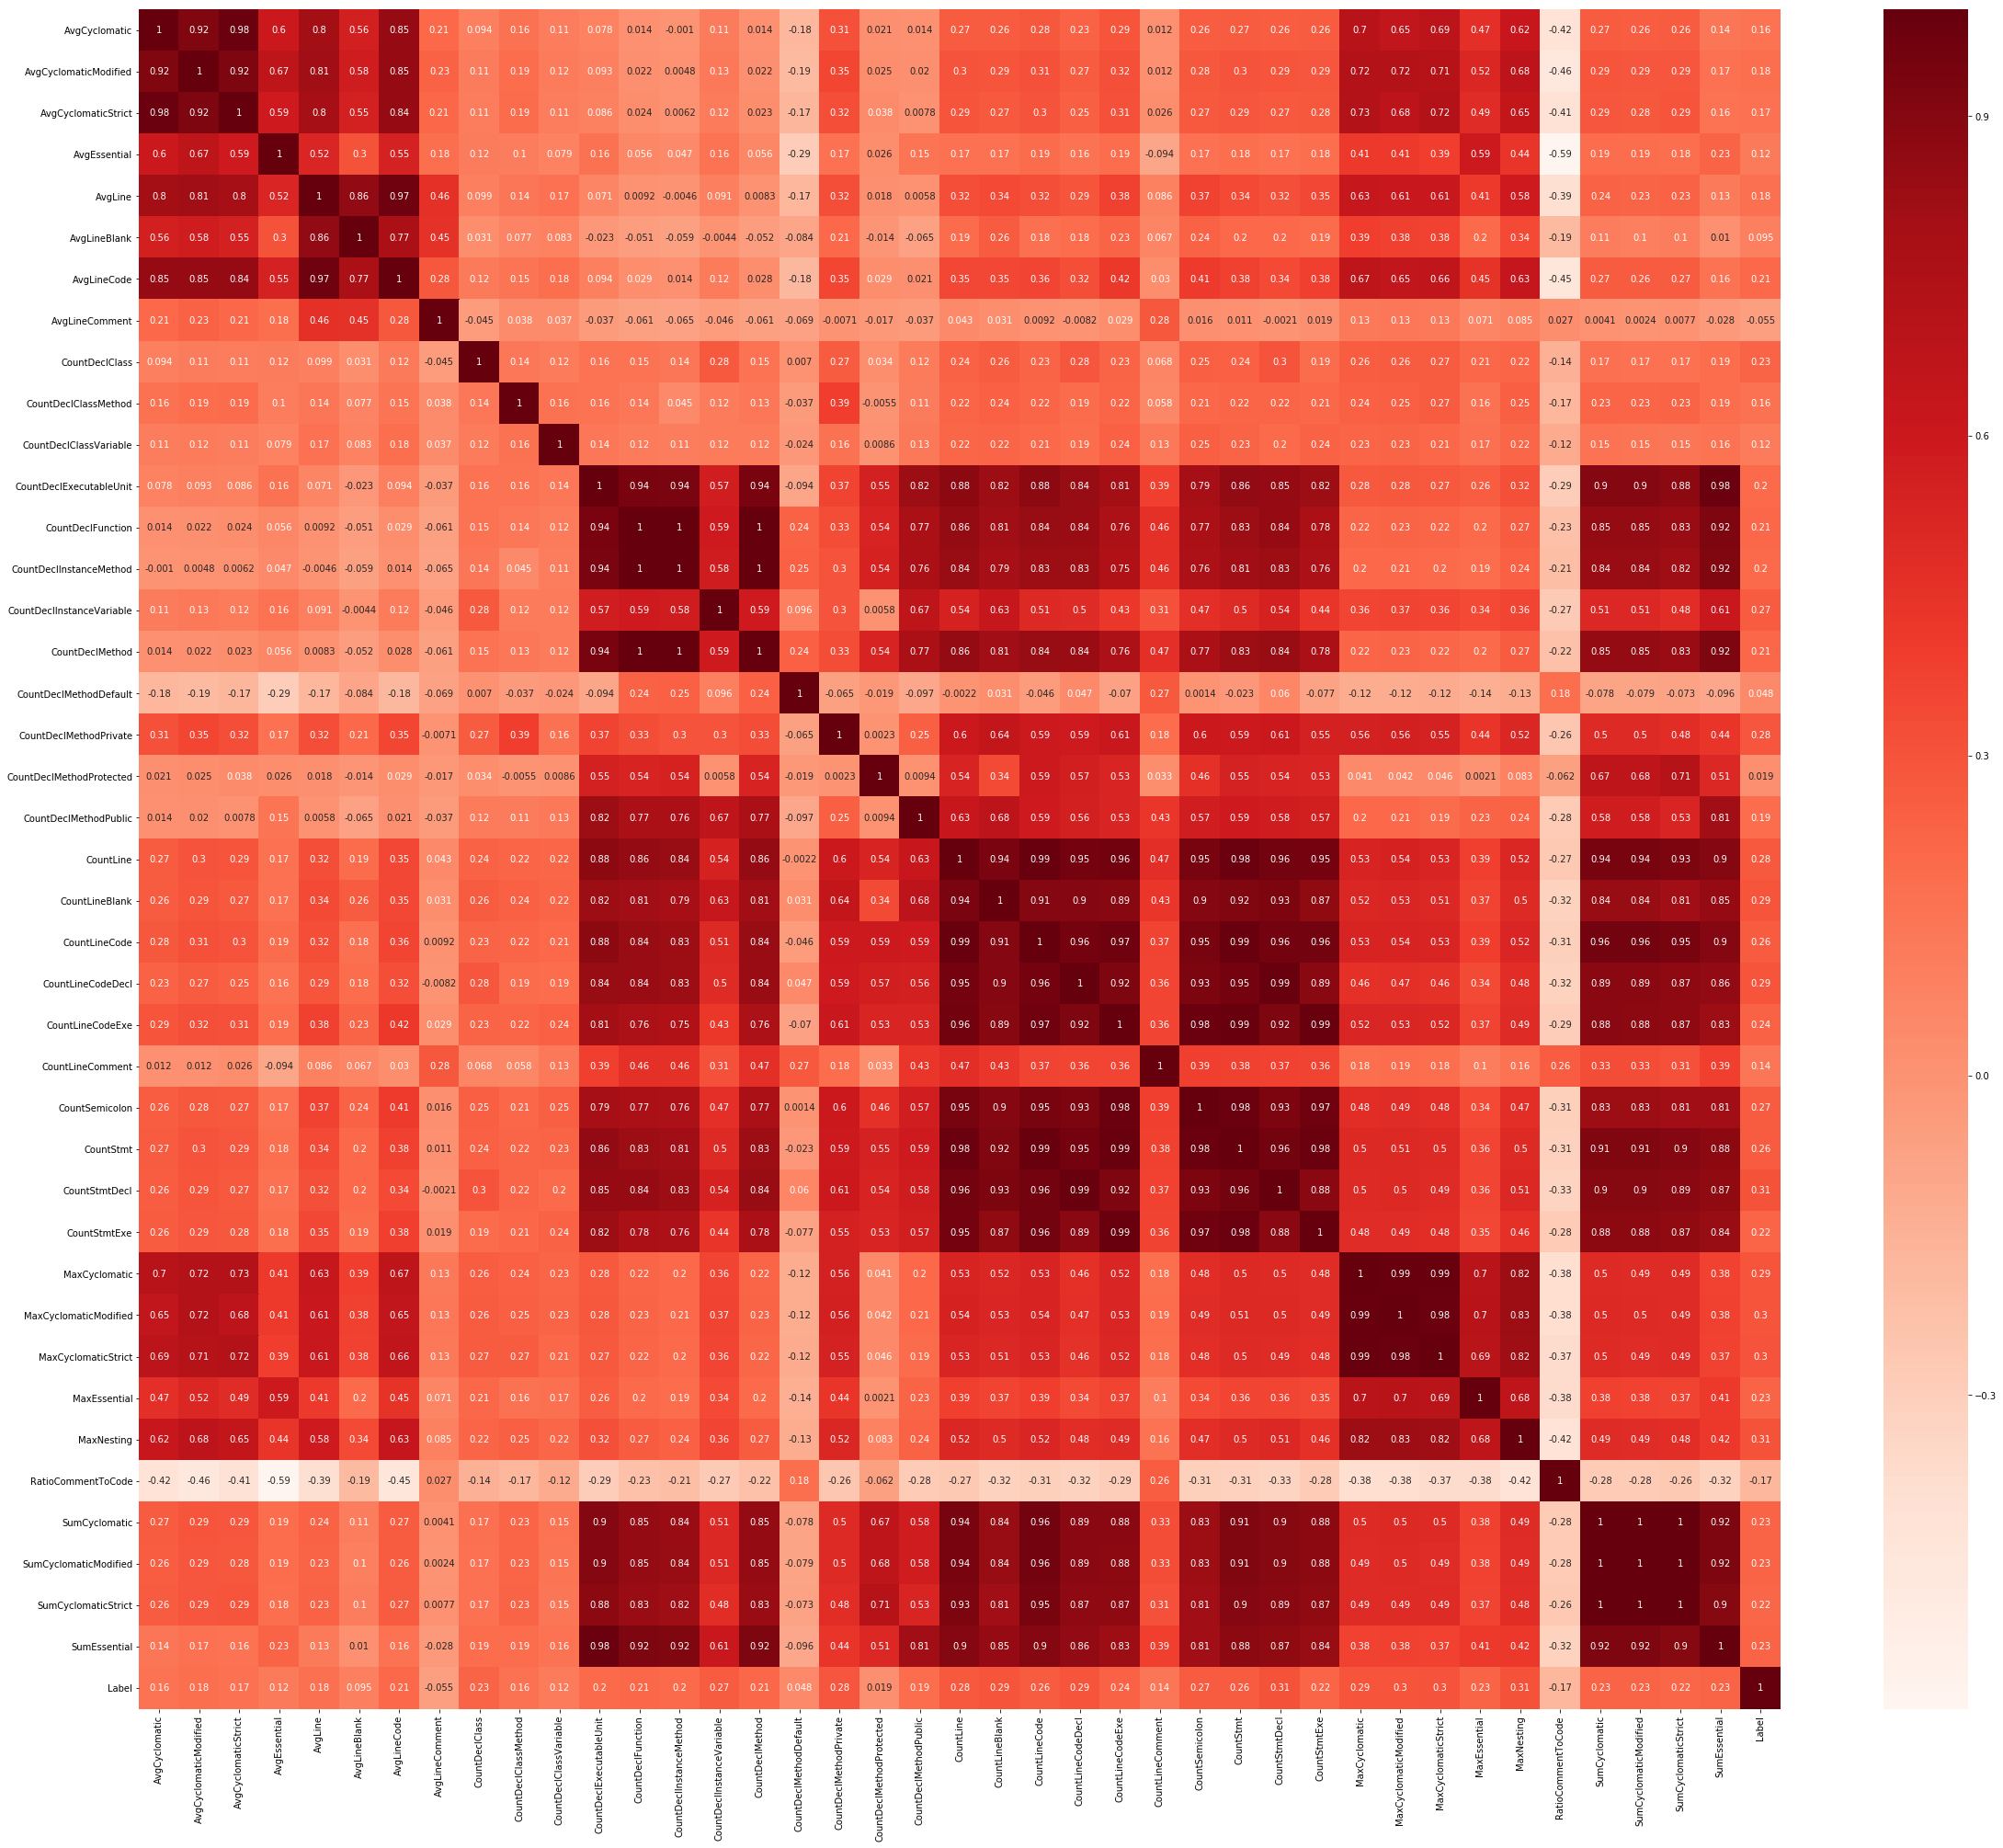

In [43]:
#Using Pearson Correlation
plt.figure(figsize=(40,34))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [44]:
#Correlation with output variable
cor_target = abs(cor["Label"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

AvgLineCode                  0.207764
CountDeclClass               0.231811
CountDeclExecutableUnit      0.201602
CountDeclFunction            0.212319
CountDeclInstanceVariable    0.265137
CountDeclMethod              0.212790
CountDeclMethodPrivate       0.284226
CountLine                    0.276033
CountLineBlank               0.292094
CountLineCode                0.264961
CountLineCodeDecl            0.293244
CountLineCodeExe             0.238504
CountSemicolon               0.265395
CountStmt                    0.264094
CountStmtDecl                0.307196
CountStmtExe                 0.223669
MaxCyclomatic                0.291471
MaxCyclomaticModified        0.295014
MaxCyclomaticStrict          0.298180
MaxEssential                 0.233720
MaxNesting                   0.307894
SumCyclomatic                0.230050
SumCyclomaticModified        0.229397
SumCyclomaticStrict          0.218673
SumEssential                 0.233626
Label                        1.000000
Name: Label,

## 2.2 Filter: Chi2

In [87]:
inputfeatures = len(df.columns) - 1
X = df.iloc[:,1:inputfeatures]
Y = df.iloc[:, inputfeatures:]

# feature extraction
test = SelectKBest(score_func=chi2, k=20)
fit = test.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(fit.get_support())
columns = fit.get_support()

[2.979e+01 3.287e+01 4.059e+01 4.276e+00 3.480e+02 4.283e+01 3.482e+02
 1.312e+01 9.417e+00 1.024e+02 9.359e+01 9.122e+02 9.200e+02 8.350e+02
 4.100e+02 9.225e+02 3.729e+01 4.128e+02 2.524e+01 5.988e+02 1.758e+04
 3.026e+03 1.746e+04 4.803e+03 8.228e+03 2.586e+02 7.189e+03 9.921e+03
 4.323e+03 5.662e+03 4.620e+02 4.691e+02 5.838e+02 1.113e+02 1.784e+02
 4.090e+01 2.788e+03 2.773e+03 3.101e+03 1.254e+03]
[False False False False False False False False False False False  True
  True  True False  True False False False  True  True  True  True  True
  True False  True  True  True  True False  True  True False False False
  True  True  True  True]


## 2.3 Wraper: Recursive Feature Elimination

In [51]:
inputfeatures = len(df.columns) - 1
X = df.iloc[:,1:inputfeatures]
Y = df.iloc[:, inputfeatures:]

# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 20)
fit = rfe.fit(X, Y)
columns = fit.support_

print("Selected Features: %s" % fit.support_)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of

Selected Features: [ True  True False  True False  True False  True  True False  True  True
 False False False False False  True False False False False False False
  True False  True  True False False False False  True  True  True  True
  True  True  True  True]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# 3.0 Split Train and Test Dataset

In [89]:
c = pd.Series(columns)
inputdf = df.iloc[:, c.values]
inputdf

,CountDeclClassVariable,CountDeclExecutableUnit,CountDeclFunction,CountDeclInstanceVariable,CountDeclMethodProtected,CountDeclMethodPublic,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineComment,CountSemicolon,CountStmt,CountStmtDecl,MaxCyclomatic,MaxCyclomaticModified,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict
5,0.0,1.0,1.0,0.0,0.0,1.0,60,9,27,14.0,24,13.0,16,12,1.0,1.0,0.89,1,1,1
8,0.0,16.0,16.0,5.0,0.0,7.0,446,51,374,131.0,21,186.0,242,122,15.0,15.0,0.06,52,52,54
9,0.0,7.0,7.0,7.0,0.0,6.0,119,21,75,25.0,23,32.0,44,22,3.0,3.0,0.31,10,10,14
10,0.0,5.0,5.0,6.0,0.0,4.0,127,21,81,41.0,25,48.0,56,36,2.0,2.0,0.31,7,7,7
11,0.0,1.0,1.0,0.0,0.0,1.0,51,5,17,8.0,29,10.0,12,7,1.0,1.0,1.71,1,1,1
12,1.0,7.0,7.0,2.0,0.0,4.0,251,34,195,77.0,22,95.0,124,73,8.0,8.0,0.11,26,26,27
13,4.0,17.0,17.0,18.0,0.0,10.0,528,77,425,130.0,26,191.0,256,123,20.0,20.0,0.06,60,60,79
14,0.0,10.0,10.0,1.0,0.0,9.0,101,18,62,22.0,21,28.0,39,21,1.0,1.0,0.34,10,10,10
15,0.0,4.0,4.0,1.0,0.0,4.0,76,11,44,19.0,21,19.0,28,19,4.0,4.0,0.48,7,7,7
16,0.0,9.0,9.0,3.0,2.0,5.0,171,24,126,39.0,21,52.0,70,34,4.0,4.0,0.17,18,18,18


In [90]:
inputfeatures = len(df.columns) - 1
# inputdf = df.iloc[:,1:inputfeatures]
outputdf = df.iloc[:, inputfeatures:]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(inputdf, outputdf, test_size=0.20, random_state=1)

# 4.0 Models

## 4.1 3-layer NN

In [92]:
model = Sequential()
model.add(Dense(350, activation = 'sigmoid', input_dim = inputdf.shape[1]))
model.add(Dense(350, activation = 'sigmoid'))
model.add(Dense(350, activation = 'sigmoid'))
model.add(Dense(outputdf.shape[1], activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, y_train, epochs = 600, verbose = True, batch_size = 1024, callbacks = [])

Epoch 1/600
664/664 [==============================] - 0s 198us/step - loss: 0.5011
Epoch 2/600
664/664 [==============================] - 0s 19us/step - loss: 0.2526
Epoch 3/600
664/664 [==============================] - 0s 19us/step - loss: 0.1779
Epoch 4/600
664/664 [==============================] - 0s 21us/step - loss: 0.1969
Epoch 5/600
664/664 [==============================] - 0s 23us/step - loss: 0.2109
Epoch 6/600
664/664 [==============================] - 0s 29us/step - loss: 0.2182
Epoch 7/600
664/664 [==============================] - 0s 20us/step - loss: 0.2220
Epoch 8/600
664/664 [==============================] - 0s 23us/step - loss: 0.2243
Epoch 9/600
664/664 [==============================] - 0s 26us/step - loss: 0.2257
Epoch 10/600
664/664 [==============================] - 0s 22us/step - loss: 0.2266
Epoch 11/600
664/664 [==============================] - 0s 22us/step - loss: 0.2272
Epoch 12/600
664/664 [==============================] - 0s 24us/step - loss: 0.2276


Epoch 99/600
664/664 [==============================] - 0s 18us/step - loss: 0.1399
Epoch 100/600
664/664 [==============================] - 0s 22us/step - loss: 0.1395
Epoch 101/600
664/664 [==============================] - 0s 22us/step - loss: 0.1391
Epoch 102/600
664/664 [==============================] - 0s 20us/step - loss: 0.1387
Epoch 103/600
664/664 [==============================] - 0s 19us/step - loss: 0.1383
Epoch 104/600
664/664 [==============================] - 0s 20us/step - loss: 0.1380
Epoch 105/600
664/664 [==============================] - 0s 18us/step - loss: 0.1376
Epoch 106/600
664/664 [==============================] - 0s 18us/step - loss: 0.1372
Epoch 107/600
664/664 [==============================] - 0s 21us/step - loss: 0.1368
Epoch 108/600
664/664 [==============================] - 0s 21us/step - loss: 0.1365
Epoch 109/600
664/664 [==============================] - 0s 20us/step - loss: 0.1361
Epoch 110/600
664/664 [==============================] - 0s 20us/s

Epoch 196/600
664/664 [==============================] - 0s 22us/step - loss: 0.1075
Epoch 197/600
664/664 [==============================] - 0s 19us/step - loss: 0.1071
Epoch 198/600
664/664 [==============================] - 0s 18us/step - loss: 0.1069
Epoch 199/600
664/664 [==============================] - 0s 20us/step - loss: 0.1069
Epoch 200/600
664/664 [==============================] - 0s 17us/step - loss: 0.1068
Epoch 201/600
664/664 [==============================] - 0s 17us/step - loss: 0.1064
Epoch 202/600
664/664 [==============================] - 0s 19us/step - loss: 0.1059
Epoch 203/600
664/664 [==============================] - 0s 18us/step - loss: 0.1052
Epoch 204/600
664/664 [==============================] - 0s 15us/step - loss: 0.1047
Epoch 205/600
664/664 [==============================] - 0s 19us/step - loss: 0.1045
Epoch 206/600
664/664 [==============================] - 0s 19us/step - loss: 0.1045
Epoch 207/600
664/664 [==============================] - 0s 20us/

Epoch 293/600
664/664 [==============================] - 0s 19us/step - loss: 0.0813
Epoch 294/600
664/664 [==============================] - 0s 20us/step - loss: 0.0802
Epoch 295/600
664/664 [==============================] - 0s 19us/step - loss: 0.0792
Epoch 296/600
664/664 [==============================] - 0s 17us/step - loss: 0.0790
Epoch 297/600
664/664 [==============================] - 0s 21us/step - loss: 0.0792
Epoch 298/600
664/664 [==============================] - 0s 21us/step - loss: 0.0795
Epoch 299/600
664/664 [==============================] - 0s 19us/step - loss: 0.0795
Epoch 300/600
664/664 [==============================] - 0s 17us/step - loss: 0.0794
Epoch 301/600
664/664 [==============================] - 0s 18us/step - loss: 0.0787
Epoch 302/600
664/664 [==============================] - 0s 18us/step - loss: 0.0779
Epoch 303/600
664/664 [==============================] - 0s 20us/step - loss: 0.0773
Epoch 304/600
664/664 [==============================] - 0s 23us/

Epoch 390/600
664/664 [==============================] - 0s 18us/step - loss: 0.0639
Epoch 391/600
664/664 [==============================] - 0s 20us/step - loss: 0.0648
Epoch 392/600
664/664 [==============================] - 0s 19us/step - loss: 0.0669
Epoch 393/600
664/664 [==============================] - 0s 19us/step - loss: 0.0665
Epoch 394/600
664/664 [==============================] - 0s 17us/step - loss: 0.0670
Epoch 395/600
664/664 [==============================] - 0s 18us/step - loss: 0.0635
Epoch 396/600
664/664 [==============================] - 0s 18us/step - loss: 0.0619
Epoch 397/600
664/664 [==============================] - 0s 19us/step - loss: 0.0624
Epoch 398/600
664/664 [==============================] - 0s 19us/step - loss: 0.0637
Epoch 399/600
664/664 [==============================] - 0s 17us/step - loss: 0.0654
Epoch 400/600
664/664 [==============================] - 0s 17us/step - loss: 0.0637
Epoch 401/600
664/664 [==============================] - 0s 19us/

Epoch 487/600
664/664 [==============================] - 0s 19us/step - loss: 0.0615
Epoch 488/600
664/664 [==============================] - 0s 18us/step - loss: 0.0576
Epoch 489/600
664/664 [==============================] - 0s 18us/step - loss: 0.0550
Epoch 490/600
664/664 [==============================] - 0s 16us/step - loss: 0.0526
Epoch 491/600
664/664 [==============================] - 0s 18us/step - loss: 0.0538
Epoch 492/600
664/664 [==============================] - 0s 21us/step - loss: 0.0576
Epoch 493/600
664/664 [==============================] - 0s 17us/step - loss: 0.0565
Epoch 494/600
664/664 [==============================] - 0s 18us/step - loss: 0.0548
Epoch 495/600
664/664 [==============================] - 0s 17us/step - loss: 0.0520
Epoch 496/600
664/664 [==============================] - 0s 18us/step - loss: 0.0537
Epoch 497/600
664/664 [==============================] - 0s 19us/step - loss: 0.0585
Epoch 498/600
664/664 [==============================] - 0s 18us/

Epoch 584/600
664/664 [==============================] - 0s 22us/step - loss: 0.0451
Epoch 585/600
664/664 [==============================] - 0s 21us/step - loss: 0.0455
Epoch 586/600
664/664 [==============================] - 0s 21us/step - loss: 0.0464
Epoch 587/600
664/664 [==============================] - 0s 22us/step - loss: 0.0472
Epoch 588/600
664/664 [==============================] - 0s 18us/step - loss: 0.0497
Epoch 589/600
664/664 [==============================] - 0s 22us/step - loss: 0.0493
Epoch 590/600
664/664 [==============================] - 0s 21us/step - loss: 0.0507
Epoch 591/600
664/664 [==============================] - 0s 18us/step - loss: 0.0474
Epoch 592/600
664/664 [==============================] - 0s 18us/step - loss: 0.0458
Epoch 593/600
664/664 [==============================] - 0s 17us/step - loss: 0.0445
Epoch 594/600
664/664 [==============================] - 0s 19us/step - loss: 0.0448
Epoch 595/600
664/664 [==============================] - 0s 17us/

In [93]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("accuracy: "+ str(accuracy))
print("precision: "+ str(precision))
print("recall: "+ str(recall))


accuracy: 0.7891566265060241
precision: 0.5
recall: 0.4


## 4.2 Naive Bayes

In [94]:
# gnb only accept shape[#sample,]
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],)

gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [95]:
y_pred = gnb.predict(X_test)
y_pred = y_pred > 0.5
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("accuracy: "+ str(accuracy))
print("precision: "+ str(precision))
print("recall: "+ str(recall))

accuracy: 0.7710843373493976
precision: 0.42105263157894735
recall: 0.22857142857142856


## 4.2 SVM

In [96]:
# clf only accept shape[#sample,]
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],)

clf = SVC(gamma='auto')
clf.fit(X_train,y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
y_pred = clf.predict(X_test)
y_pred = y_pred > 0.5
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("accuracy: "+ str(accuracy))
print("precision: "+ str(precision))
print("recall: "+ str(recall))

accuracy: 0.8012048192771084
precision: 0.6666666666666666
recall: 0.11428571428571428
